In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns;sns.set_style("ticks")
from operator import itemgetter
import os

figures_folder = "/Users/annasintsova/git_repos/HUTI-RNAseq/figures/differential_expression_analysis/"
results_folder = "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/"

today = dt.datetime.today().strftime("%Y-%m-%d")

meta_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/data/huti_patient_info_short.csv"
meta = pd.read_csv(meta_file, index_col=0)
meta

def sample_label(strain, treat, join = " | "):
    return strain+join+treat

col1 = "#f34236"
col2 = "#d6c571"
col3 = "#88bc67"
col4 = "#2e8174"
col5 = "#143969"
colors = [col1, col2, col3, col4, col5]
my_cmap = LinearSegmentedColormap.from_list('custom blue', [col5, col4, col2,col1], N=256)
ur = "URINE"
uti = "PATIENT"
join = " | "

# DESeq2 normalized counts
data = "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/deseq_norm_counts.csv"        
data = pd.read_csv(data, index_col=0)
col_names = sorted([tuple(c.split("_")) for c in data.columns], key=itemgetter(1,0))
col_names = ["_".join(c) for c in col_names]
df = data[col_names]
df.columns = [sample_label(c.split("_")[0], ur) if "UR" in c else sample_label(c.split("_")[0], uti) for c in df.columns]


de_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/best_strains_DEseq.csv"
de_all_genes = pd.read_csv(de_file, index_col=0)
de_all_genes.head()
de_up = de_all_genes[(de_all_genes.log2FoldChange > 2) &( de_all_genes.padj < 0.01)]
de_down = de_all_genes[(de_all_genes.log2FoldChange <-2 ) &( de_all_genes.padj < 0.01)]

strain_qual = {'good':["HM56", "HM14", "HM43", "HM54", "HM86"],
              'okay':["HM56", "HM14", "HM43", "HM54", "HM86","HM01", "HM03", "HM06", "HM68"],
              'so-so':["HM57", "HM17", "HM07" "HM60"],
              'bad': ["HM66"]}


In [53]:
###

de_up.to_csv(os.path.join(results_folder, today+"_UPREGULATED.csv"))
de_down.to_csv(os.path.join(results_folder, today+"_DOWNREGULATED.csv"))
up_gene_names_file = os.path.join(results_folder, today+"_up_gene_names.txt")
down_gene_names_file = os.path.join(results_folder, today+"_down_gene_names.txt")
all_gene_names_file = os.path.join(results_folder, today+"_all_gene_names.txt")
with open (up_gene_names_file, "w") as fo:
    for gene in de_up.index:
        fo.write("{}\n".format(gene))
with open(down_gene_names_file, "w") as fo:
    for gene in de_down.index:
        fo.write("{}\n".format(gene))
with open(all_gene_names_file, "w") as fo:
    for gene in de_all_genes.index:
        fo.write("{}\n".format(gene))
# Run KEGG API

In [2]:
gene_info_file = os.path.join(results_folder, "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/2018-05-24_all_gene_names_info.tab")
gene_info = pd.read_csv(gene_info_file, sep="\t", header=None, index_col=0,
                        names=["","gene_name", "function", "pathway"])
fx = gene_info.function
fx = fx.str.replace("\(RefSeq\)", "")
gene_info.function = fx
gene_info
df_all = de_all_genes[["baseMean", "log2FoldChange","padj"]]
df_all = df_all.merge(gene_info, how="left", left_index=True, right_index=True).sort_index()
df_all.head()

,baseMean,log2FoldChange,padj,gene_name,function,pathway
b0002,2524.965484,-0.055712,0.894307,thrA,Bifunctional aspartokinase/homoserine dehydro...,"eco00260 Glycine, serine and threonine metabo..."
b0003,1336.270850,-0.382777,0.487691,thrB,homoserine kinase,"eco00260 Glycine, serine and threonine metabo..."
b0004,1067.553271,-0.364933,0.456064,thrC,L-threonine synthase,"eco00260 Glycine, serine and threonine metabo..."
b0006,2319.560051,0.937212,0.020111,yaaA,"peroxide resistance protein, lowers intracell...",NaN
b0007,237.375000,-1.394198,0.000006,yaaJ,putative transporter,NaN


In [3]:
gene_info_file = os.path.join(results_folder, "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/2018-05-24_up_gene_names_info.tab.txt")
gene_info = pd.read_csv(gene_info_file, sep="\t", header=None, index_col=0,
                        names=["gene_name", "function", "pathway"])
fx = gene_info.function
fx = fx.str.replace("\(RefSeq\)", "")
gene_info.function = fx
gene_info
df_up = de_up[["baseMean", "log2FoldChange","padj"]]
df_up = df_up.merge(gene_info, how="left", left_index=True, right_index=True).sort_index()
df_up.head()

#df_up.to_excel(os.path.join(results_folder, "UP_CHANGES_IN_GENE_EXPRESSION_IN_PATIENTS.xlsx"))

,baseMean,log2FoldChange,padj,gene_name,function,pathway
b0010,1172.258784,2.908446,2.750000e-06,satP,succinate-acetate transporter,NaN
b0013,65.848454,2.501710,3.835130e-04,yaaI,UPF0412 family protein,NaN
b0023,11151.703810,2.403709,1.260000e-17,rpsT,30S ribosomal subunit protein S20,eco03010 Ribosome
b0048,1274.772119,2.397252,2.500000e-52,folA,dihydrofolate reductase,"eco00670 One carbon pool by folate, eco00790 ..."
b0058,527.258884,2.085799,2.760000e-09,rluA,"dual specificity 23S rRNA pseudouridine(746),...",NaN


In [4]:
gene_info_file = os.path.join(results_folder, "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/2018-05-24_down_gene_names_info.tab")
gene_info = pd.read_csv(gene_info_file, sep="\t", header=None, index_col=0,
                        names=["","gene_name", "function", "pathway"])

fx = gene_info.function
fx = fx.str.replace("\(RefSeq\)", "")
gene_info.function = fx
gene_info
df_down = de_down[["baseMean", "log2FoldChange","padj"]]
df_down = df_down.merge(gene_info, how="left", left_index=True, right_index=True).sort_index()
df_down.head()
#df_down.to_excel(os.path.join(results_folder, "DOWN_CHANGES_IN_GENE_EXPRESSION_IN_PATIENTS.xlsx"))

,baseMean,log2FoldChange,padj,gene_name,function,pathway
b0061,122.611605,-3.181688,2.290000e-05,araD,L-ribulose-5-phosphate 4-epimerase,eco00040 Pentose and glucuronate interconvers...
b0062,356.064598,-3.642759,1.230000e-09,araA,L-arabinose isomerase,eco00040 Pentose and glucuronate interconvers...
b0063,293.901383,-3.802945,3.480000e-07,araB,L-ribulokinase,eco00040 Pentose and glucuronate interconvers...
b0071,5679.636684,-4.546992,1.570000e-08,leuD,3-isopropylmalate dehydratase small subunit,"eco00290 Valine, leucine and isoleucine biosy..."
b0072,13398.715840,-4.372419,3.300000e-08,leuC,3-isopropylmalate dehydratase large subunit,"eco00290 Valine, leucine and isoleucine biosy..."


In [5]:
def get_subset_genes(df, key, col_return,column_name="function"):
    keep = []
    for i, x in zip(df.index, df[column_name]):
        if not type(x) == str:
            continue
        if key in x:
            keep.append(i)
    return df.loc[keep][col_return]

In [6]:
# UP

ribosome = get_subset_genes(df_up, "ibosom", ["baseMean","log2FoldChange", "gene_name", "function"])
rRNA = get_subset_genes(df_up, "rRNA", ["baseMean","log2FoldChange", "gene_name", "function"])
rna_helicase = get_subset_genes(df_up, "helicase", ["baseMean","log2FoldChange", "gene_name", "function"])
tRNA = get_subset_genes(df_up, "tRNA",["baseMean","log2FoldChange", "gene_name", "function"])
purine = get_subset_genes(df_up, "urine",["baseMean","log2FoldChange", "gene_name", "function", "pathway"], "pathway")
pyrimidine = get_subset_genes(df_up, "yrimidine",["baseMean","log2FoldChange", "gene_name", "function", "pathway"], "pathway")
all_trans = get_subset_genes(df_up, "transport",["baseMean","log2FoldChange", "gene_name", "function"])
aa_t = ["b1605", "b1907", "b2156", "b2678", "b2679", "b2796", "b2845",
       "b3184", "b3539", "b3795", "b3827", "b4156"]
aa_trans = df_up.loc[aa_t][["baseMean","log2FoldChange", "gene_name", "function"]]


In [7]:
up_subsets={"Ribosomal Subunits":(ribosome, ribosome.shape[0]),
             "rRNA Modification":(rRNA, rRNA.shape[0]),
            "RNA Helicases": (rna_helicase, rna_helicase.shape[0]),
           "tRNA Synthesis/Modification": (tRNA, tRNA.shape[0]),
           "Purine Metabolism":(purine, purine.shape[0]),
           "Pyrimidine Metabolism":(pyrimidine, pyrimidine.shape[0]),
           "Amino Acid Transporters":(aa_trans, aa_trans.shape[0])}


In [8]:

def find_subset_means(dict_of_subsets, rpkms, qual = ""):
    means_list = []
    lab_list = []
    num_genes = []
    for lab, sub in dict_of_subsets.items():
        if not qual:
            subset_rpkms = df.loc[sub[0].index]
        else:
            subset_rpkms = df.loc[sub[0].index][[c for c in rpkms.columns if c.split(join)[0] in strain_qual[qual]]]
        means_list.append(subset_rpkms.mean())
        lab_list.append(lab)
        num_genes.append(sub[1])
        
    fDf = pd.concat(means_list, axis=1, keys =lab_list )
    fDf = fDf.T
    fDf.index = ["{} (n={})".format(c,n) for c,n in zip(fDf.index, num_genes)]
    return fDf

up_data = find_subset_means(up_subsets, df, )
up_data.head()
# NOT HAPPY WITH MY RPKMS?? Use normalized counts from DESeq2

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Ribosomal Subunits (n=45),2946.775949,2823.484553,5208.789734,2690.027144,3349.717381,5908.380731,5528.698709,5421.825879,6293.743919,3944.445418,...,32896.664783,29184.695477,23268.637566,21912.962019,33870.655547,21423.270556,21557.081281,13235.874770,21420.209331,25094.757680
rRNA Modification (n=10),263.701412,325.262568,484.108968,261.857497,228.691476,268.147585,187.163281,216.913794,153.159436,167.942310,...,961.344885,1658.884954,913.253149,1322.187672,1161.761159,1212.050042,1143.860643,841.382066,1388.919441,1308.285207
RNA Helicases (n=4),826.379997,606.556417,1039.609006,642.868853,542.532711,770.305952,652.125333,658.166258,572.620289,532.386437,...,2468.370324,4536.013547,3092.825782,8103.361512,6623.859887,5418.576657,6293.906111,2061.386062,5741.516731,3353.374479
tRNA Synthesis/Modification (n=15),419.075785,516.116695,869.640192,397.973441,383.150624,468.227683,327.364710,328.254945,271.138691,221.051608,...,2699.921348,4685.118151,2060.804591,2743.341722,3985.754230,3066.301761,3120.138254,1968.834035,4167.318416,3779.575705
Purine Metabolism (n=6),2390.090283,2272.772299,4150.008203,2186.293782,2506.609314,4031.731582,3636.564229,3918.556197,3970.823472,2554.704691,...,20856.269930,22653.121119,15884.142289,16970.698047,23189.992648,15034.437718,17749.438832,11372.680928,19657.595620,18957.454354


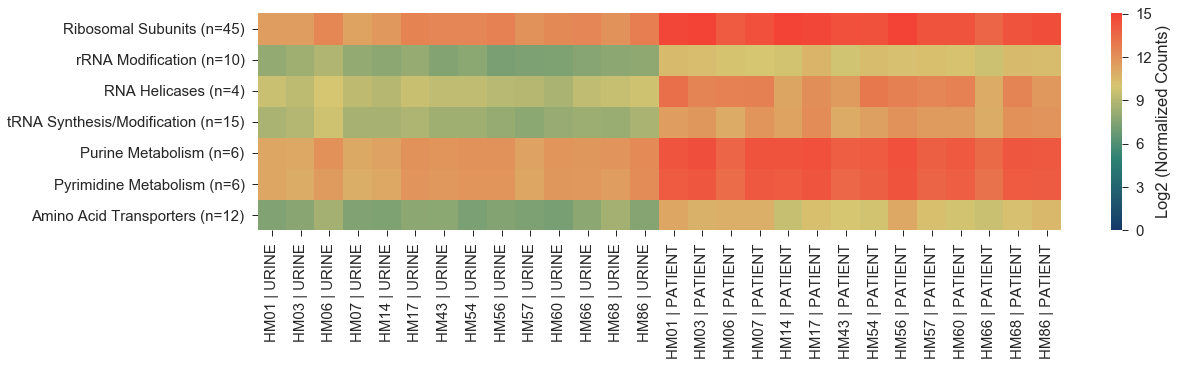

In [9]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(18,4))
sns.heatmap(np.log2(up_data+1), cmap=my_cmap, vmin=0, cbar_kws={'label': 'Log2 (Normalized Counts)'})
#fn = os.path.join(figures_folder, today+"_figure_4a_v1.png")
#fig.savefig(fn, dpi=500, bbox_inches="tight")

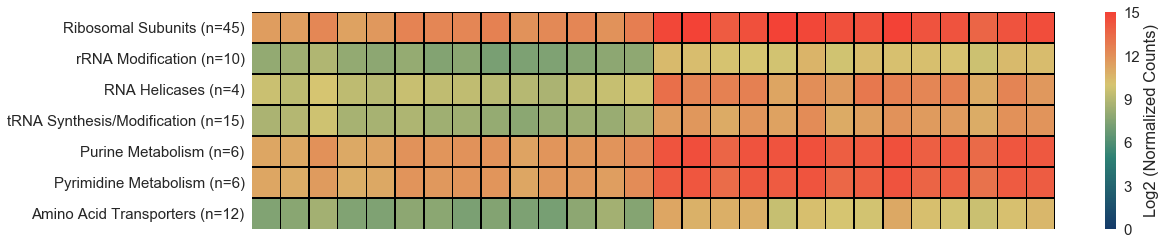

In [21]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(18,4))
sns.heatmap(np.log2(up_data+1), cmap=my_cmap, linewidths=0.5, linecolor='black',
            vmin=0, cbar_kws={'label': 'Log2 (Normalized Counts)'})
ax = fig.gca()
ax.set_xticklabels("")
fn = os.path.join(figures_folder, today+"_figure_4a_v2.png")
fig.savefig(fn, dpi=500, bbox_inches="tight")

In [12]:
arginine = get_subset_genes(df_down, "Arginine", ["baseMean","log2FoldChange", 
                                                  "gene_name", "function","pathway"], "pathway")

val = get_subset_genes(df_down, "Valine", ["baseMean","log2FoldChange", 
                                                  "gene_name", "function","pathway"], "pathway")

maltose = get_subset_genes(df_down, "maltose", ["baseMean","log2FoldChange", 
                                                  "gene_name", "function"])
cys = get_subset_genes(df_down, "Cysteine",["baseMean","log2FoldChange", 
                                                  "gene_name", "function", "pathway"], "pathway" )

glycine = get_subset_genes(df_down, "Glycine",["baseMean","log2FoldChange", 
                                                  "gene_name", "function", "pathway"], "pathway" )
galactose = get_subset_genes(df_down, "Galactose",["baseMean","log2FoldChange", 
                                                  "gene_name", "function", "pathway"], "pathway" )

starch =  get_subset_genes(df_down, "Starch",["baseMean","log2FoldChange", 
                                                  "gene_name", "function", "pathway"], "pathway" )
biofilm =  get_subset_genes(df_down, "Biofilm",["baseMean","log2FoldChange", 
                                                  "gene_name", "function", "pathway"], "pathway" )
biofilm2 = get_subset_genes(df_down, "iofilm",["baseMean","log2FoldChange", 
                                                  "gene_name", "function", "pathway"] )
biofilm3 = get_subset_genes(df_down, "curli", ["baseMean","log2FoldChange", 
                                                  "gene_name", "function", "pathway"] )
Biofilm = pd.concat([biofilm, biofilm2, biofilm3]).drop_duplicates()

transp = get_subset_genes(df_down, "transporter", ["baseMean","log2FoldChange", 
                                                  "gene_name", "function", "pathway"] )
sugar_transp = ["b1900", "b2149", "b2150", "b3093", "b3566", "b3567", "b3568", "b3691",
               "b3750", "b3751", "b4227", "b4230", "b4460", "b4485"]
sugar_trans = df_down.loc[sugar_transp][["baseMean","log2FoldChange", "gene_name", "function"]]


In [13]:
down_subsets = {"Arginine Metabolism":(arginine, arginine.shape[0]),
               "Val/Leu/Ileu Metabolism":(val, val.shape[0]),
               "Cys/Met Metabolism": (cys, cys.shape[0]),
               "Gly/Ser/Thr Metabolism": (glycine, glycine.shape[0]),
               "Maltose Metabolism": (maltose, maltose.shape[0]),
               "Galactose Metabolism": (galactose, galactose.shape[0]),
               "Starch/Sucrose Metabolism": (starch, starch.shape[0]),
                "Sugar Transporters":(sugar_trans, sugar_trans.shape[0]),
               "Biofilm/Curli":(Biofilm, Biofilm.shape[0])}



In [14]:
down_data = find_subset_means(down_subsets, df, )
down_data.head()

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Arginine Metabolism (n=9),4065.878321,3724.800930,4890.792230,1949.636333,6206.768160,3470.706276,3096.547075,6896.670845,6282.175410,2523.747981,...,1061.427231,692.912960,618.668722,343.981238,399.703841,275.505928,364.657547,420.691033,462.637091,846.827856
Val/Leu/Ileu Metabolism (n=12),1315.228160,5054.292258,6360.968832,4727.997453,985.312496,17860.895242,2085.863152,1904.151119,14232.024084,1337.595053,...,219.571209,348.595100,498.178219,277.364235,308.321425,213.891184,140.755437,364.598895,234.679105,439.903666
Cys/Met Metabolism (n=8),8614.074061,10360.169656,16597.555401,5507.771703,22730.194888,35171.455030,28714.576304,26203.046278,33507.396036,41538.171197,...,1916.594158,978.418764,1848.729314,834.294784,615.587470,516.903694,537.186891,915.002997,885.507555,1184.388759
Gly/Ser/Thr Metabolism (n=8),4320.063351,4630.960369,4664.626353,3605.625196,5630.126023,7110.212201,5663.559552,6710.878426,6504.302662,6494.425762,...,1228.283341,615.922632,986.422308,821.522719,669.562566,484.225875,466.363744,620.519274,643.547237,1027.683052
Maltose Metabolism (n=5),5326.698398,794.873805,3620.370467,471.370256,3695.154807,158.444232,901.124660,5102.558379,1726.090516,1872.665410,...,14.234838,37.981896,518.438938,29.830846,50.416961,98.231507,83.384234,218.759337,36.966160,46.724472


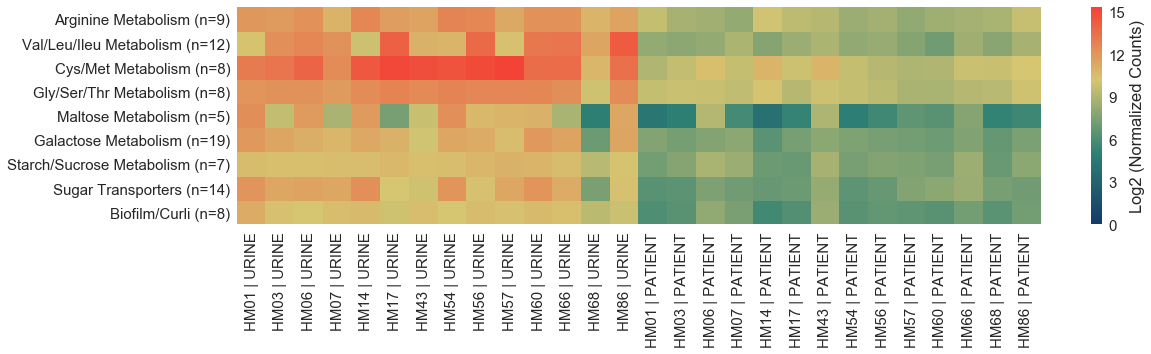

In [16]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(18,4))
sns.heatmap(np.log2(down_data+1), cmap=my_cmap, vmin=0, cbar_kws={'label': 'Log2 (Normalized Counts)'})
ax = fig.gca()
#fn = os.path.join(figures_folder, today+"_figure_4b_v1.png")
#fig.savefig(fn, dpi=500, bbox_inches="tight")

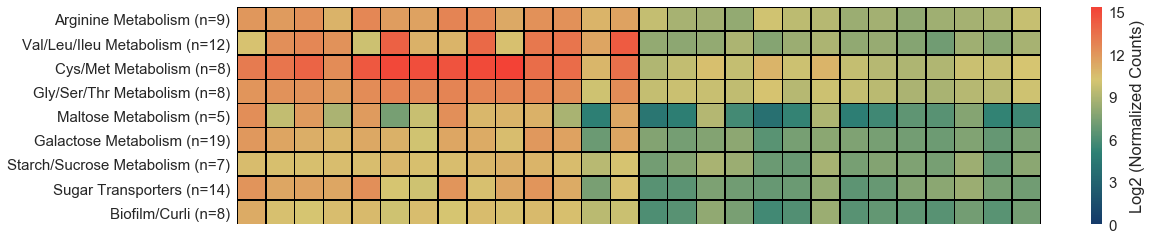

In [22]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(18,4))
sns.heatmap(np.log2(down_data+1), cmap=my_cmap, vmin=0, linecolor="black", linewidths=0.5,
            cbar_kws={'label': 'Log2 (Normalized Counts)'});
ax = fig.gca()
ax.set_xticklabels("")
fn = os.path.join(figures_folder, today+"_figure_4b_v2.png")
fig.savefig(fn, dpi=500, bbox_inches="tight")

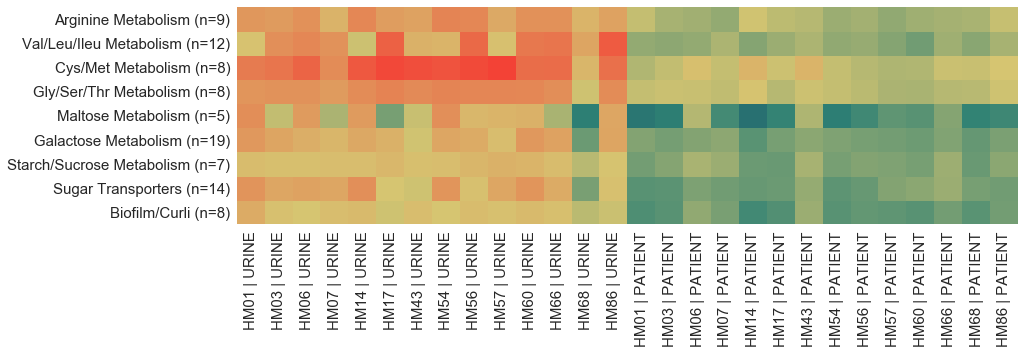

In [259]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(14,4))
sns.heatmap(np.log2(down_data+1), cmap=my_cmap, vmin=0, cbar=False)
#fn = os.path.join(figures_folder, today+"_figure_4b_v1.png")
#fig.savefig(fn, dpi=500, bbox_inches="tight")